# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

from IPython.display import display
from nltk.corpus import wordnet
from numpy.random import seed
from scipy import spatial
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from typing import Dict, List, Tuple

from src.robin.supply.entities import Supply

SEED = 27

os.environ['PYTHONHASHSEED'] = str(SEED)  # Set python hash seed
np.random.seed(SEED)  # Set numpy random seed
random.seed(SEED)  # Set random seed
tf.random.set_seed(SEED)  # Set tensorflow random seed

SAVE_PATH = '../reports/figures/ae_interpretability/'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

2023-07-28 12:59:06.245300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Tensorflow version
print(tf.__version__)

2.12.0


In [4]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
def get_paths_from_supply(path_config_supply: str = '../configs/test_case/supply_data.yml') -> List[List[str]]:
    """
    Get the paths of a supply

    Args:
        path_config_supply (str, optional): Path to the supply config file. Defaults to '../configs/test_case/supply_data.yml'.

    Returns:
        List[List[str]]: List of paths
    """
    supply = Supply.from_yaml(path_config_supply)

    # Get set of corridors
    corridors = []
    for service in supply.services:
        if service.line.corridor not in corridors:
            corridors.append(service.line.corridor)

    # Get set of paths
    paths = []
    for corridor in corridors:
        for path in corridor.paths:
            if path not in paths:
                paths.append(path)

    # Parse paths of Station objects to paths of station mame
    paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
    return paths

paths = get_paths_from_supply()
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [6]:
def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [7]:
def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_csv_path = f'../data/renfe/renfe_stations.csv'
stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [8]:
def simulate_passengers_data(paths: list,
                             user_patterns: list,
                             n_passengers: int = 10000,
                             seed: int = 42
    ) -> pd.DataFrame:
    # Set random state
    random.seed(seed)

    pairs = []
    for _ in range(n_passengers):
        pairs.append(get_random_pair(paths))

    df = pd.DataFrame(pairs, columns=['origin', 'destination'])
    df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

    random_days = lambda: random.randint(0, 364)
    random_hours = lambda: random.randint(0, 23)
    random_minutes = lambda: random.randint(0,60)

    random_timedelta = lambda: datetime.timedelta(days=random_days(), hours=random_hours(), minutes=random_minutes())
    df['date'] = [datetime.datetime(2023, 1, 1) + random_timedelta() for _ in range(n_passengers)]
    return df

user_patterns = ("business", "student", "tourist")
df = simulate_passengers_data(paths, user_patterns, n_passengers=10000)

display(df.head())

,origin,destination,user_pattern,date
0,madrid,tarragona,tourist,2023-10-17 14:39:00
1,zaragoza,tarragona,business,2023-11-16 23:52:00
2,guadalajara,barcelona,business,2023-10-29 01:46:00
3,madrid,guadalajara,student,2023-12-16 07:48:00
4,zaragoza,tarragona,student,2023-03-13 07:35:00


In [9]:
class AutoencoderEmbedding:
    """
    Class to get the embedding of a dataframe to be used as input of an autoencoder

    Attributes:
        df (pd.DataFrame): Dataframe with the data to be embedded
        scaler (MinMaxScaler): Scaler to normalize the data.
        df_time (pd.DataFrame): Dataframe with the time embedding.
        noise (bool): Whether to add noise to the embedding or not.
        embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        df_noisy (pd.DataFrame): Dataframe with the noisy embedding.
        word_index (dict): Dictionary with the index of each word.
        embedding_dict (dict): Dictionary with the embedding.
        df_embedding_noisy (pd.DataFrame): Dataframe with the noisy embedding.
        embedding_noisy_arrays (np.array): Array with the noisy embedding.
        df_embedding (pd.DataFrame): Dataframe with the embedding.
        embedding_arrays (np.array): Array with the embedding.
    """
    def __init__(self, df: pd.DataFrame, embedding_dim: int = 50, noise: bool = True):
        """
        Constructor method

        Args:
            df (pd.DataFrame): Dataframe with the data to be embedded
            embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        """
        self.df = df
        self.scaler = MinMaxScaler(feature_range=(-2, 2))
        self.df_time = self._get_datetime_df()
        self.noise = noise
        self.embedding_dim = embedding_dim
        if self.noise:
            self.df_noisy = self._get_noisy_df()

        df_bag_words = pd.concat([self.df_noisy, self.df], ignore_index=True) if self.noise else self.df
        words_set = set(df_bag_words[['origin', 'destination', 'user_pattern']].values.flatten())
        self.word_index = {word: index for index, word in enumerate(words_set)}
        self.embedding_dict = self._get_embedding_dict()

        if self.noise:
            self.df_embedding_noisy = self._get_embedding_df(self.df_noisy)
            self.embedding_noisy_arrays = self._get_embedding_arrays(self.df_embedding_noisy)
        self.df_embedding = self._get_embedding_df(self.df)
        self.embedding_arrays = self._get_embedding_arrays(self.df_embedding)
        self.shap_dict = self._get_shap_dict()

    def _get_shap_dict(self):
        shap_dict = {}
        return shap_dict

    def _get_datetime_df(self) -> pd.DataFrame:
        """
        Get time features dataframe.

        Returns:
            pd.DataFrame: Dataframe with the time features.
        """
        def encode(data, column, max_val: int,  zero_index: bool = False):
            if not zero_index:
                data[column] -= 1
            data[column + '_sin'] = np.sin(2 * np.pi * data[column]/max_val)
            data[column + '_cos'] = np.cos(2 * np.pi * data[column]/max_val)
            return data

        df_datetime = pd.DataFrame()
        df_datetime['month'] = self.df['date'].dt.month
        df_datetime = encode(df_datetime, 'month', max_val=12)
        df_datetime['day'] = self.df['date'].dt.day
        df_datetime = encode(df_datetime, 'day', max_val=31)
        df_datetime['minutes'] = self.df['date'].dt.hour * 60 + self.df['date'].dt.minute
        df_datetime = encode(df_datetime, 'minutes', max_val = 24*60, zero_index=True)

        cyclical_cols = ['month_cos', 'month_sin', 'day_cos', 'day_sin', 'minutes_cos', 'minutes_sin']
        df_datetime[cyclical_cols] = self.scaler.fit_transform(df_datetime[cyclical_cols])

        return df_datetime

    def _get_embedding_arrays(self, df: pd.DataFrame) -> np.array:
        """
        Get the words embedding.

        Args:
            df (pd.DataFrame, optional): Dataframe with the data to be embedded. Defaults to None.

        Returns:
            np.array: Array with the words embedding.
        """
        input_data = df[['origin', 'destination', 'user_pattern', 'date']].values.tolist()
        embedding_arrays = np.array([np.asarray(row, dtype=np.float32) for row in input_data])
        # np.expand_dims(embedding_arrays, axis=-1)
        return embedding_arrays

    def _get_embedding_dict(self) -> Dict[str, np.array]:
        """
        Get the words embedding dictionary

        Returns:
            Dict[str, np.array]: Dictionary with the embedding.
        """
        embeddings_index = {}
        f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

        # Read GloVe embeddings
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = coefs
        f.close()

        # Create embedding matrix
        embedding_matrix = np.zeros((len(self.word_index) + 1, self.embedding_dim))
        embedding_dict = {}
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word, np.zeros(self.embedding_dim))
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embedding_dict[word] = embedding_vector

        return embedding_dict

    def decode_time_embedding(self, encoded_time_vector):

        def decode(val_cos, val_sin, max_val, zero_index: bool = False) -> int:
            angle = np.arctan2(val_sin, val_cos)
            val = (angle / (2 * np.pi)) * max_val
            val = int(round(val) % max_val)
            if not zero_index:
                return val + 1
            return val

        encoded_time_vector = self.scaler.inverse_transform(encoded_time_vector[:8])[0]
        month = decode(encoded_time_vector[0], encoded_time_vector[1], max_val=12)
        day = decode(encoded_time_vector[2], encoded_time_vector[3], max_val=31)
        minutes = decode(encoded_time_vector[4], encoded_time_vector[5], max_val=24*60, zero_index=True)
        hour = minutes // 60
        minute = minutes % 60
        return month, day, hour, minute

    def get_word_syn(self, word: str) -> str:
        """
        Get a random synonym of a word

        Args:
            word (str): Word to get the synonym from

        Returns:
            str: Synonym of the word
        """
        word_synset = wordnet.synsets(word)
        if len(word_synset) > 0:
            station_synset = word_synset[0]
            station_lemmas = station_synset.lemmas()
            if len(station_lemmas) > 0:
                word_lemma = random.choice(station_lemmas)
                return word_lemma.name().lower()

        return word

    def _get_noisy_df(self, p: float = 0.2) -> pd.DataFrame:
        """
        Get the noisy embedding dataframe by replacing some of the words with synonyms

        Returns:
            pd.DataFrame: Noisy embedding dataframe.
        """
        df_noisy = self.df.copy()
        df_noisy['origin'] = df_noisy['origin'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['destination'] = df_noisy['destination'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['user_pattern'] = df_noisy['user_pattern'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)

        return df_noisy

    def _get_embedding_df(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Get embedding dataframe.

        Returns:
            pd.DataFrame: Embedding dataframe.
        """
        df_embedding = df.copy()
        df_embedding['origin'] = df_embedding['origin'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['destination'] = df_embedding['destination'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['user_pattern'] = df_embedding['user_pattern'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['date'] = self.df_time[['month_cos',
                                               'month_sin',
                                               'day_cos',
                                               'day_sin',
                                               'minutes_cos',
                                               'minutes_sin']].apply(lambda row: np.array(row), axis=1)

        df_embedding['date'] = df_embedding['date'].apply(lambda x: np.pad(x, (0, self.embedding_dim - len(x)), 'constant', constant_values=np.float32(0.0)))
        return df_embedding[['origin', 'destination', 'user_pattern', 'date']]

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

EMBEDDING_DIM = 50

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

train_embedding = AutoencoderEmbedding(df = df_train, embedding_dim=EMBEDDING_DIM)
test_embedding = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM, noise=False)

print("Header of train data:")
display(train_embedding.df.head())

print("Header of test data:")
display(test_embedding.df.head())

Train data shape:  (7000, 4)
Test data shape:  (3000, 4)
Header of train data:


,origin,destination,user_pattern,date
9069,tarragona,girona,student,2023-06-18 13:19:00
2603,zaragoza,girona,tourist,2023-03-13 18:41:00
7738,lleida,figueres,tourist,2023-12-25 05:55:00
1579,zaragoza,figueres,student,2023-11-22 02:15:00
5058,zaragoza,lleida,student,2023-05-05 23:16:00


Header of test data:


,origin,destination,user_pattern,date
6252,zaragoza,lleida,student,2023-05-18 23:37:00
4684,girona,figueres,tourist,2023-04-25 04:39:00
1731,guadalajara,figueres,business,2023-10-17 10:38:00
4742,guadalajara,girona,student,2023-08-17 01:17:00
4521,madrid,figueres,student,2023-02-17 18:07:00


In [11]:
print(test_embedding.embedding_arrays.shape)

(3000, 4, 50)


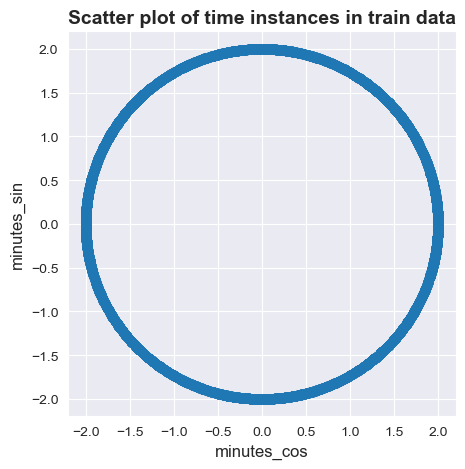

In [12]:
# Scatter plot 'minutes_cos' and 'minutes_sin' columns of train_embedding.df_time

plt.figure(figsize=(5, 5))
plt.title("Scatter plot of time instances in train data", weight='bold', fontsize=14)
plt.scatter(train_embedding.df_time['minutes_cos'], train_embedding.df_time['minutes_sin'])
plt.xlabel('minutes_cos', fontsize=12)
plt.ylabel('minutes_sin', fontsize=12)
plt.savefig(SAVE_PATH + 'scatter_time_plot.png', dpi=300)
plt.show()

## Autoencoder model

In [13]:
def custom_loss(y_true, y_pred):
    # Split last array in sub_arrays of size 2
    true_segments = tf.split(y_true[:, -1], num_or_size_splits=[2, 2, 2, EMBEDDING_DIM-6], axis=1)
    pred_segments = tf.split(y_pred[:, -1], num_or_size_splits=[2, 2, 2, EMBEDDING_DIM-6], axis=1)

    # Calculate difference between true and predicted segments
    segment_losses = [K.square(true_segment - pred_segment) for true_segment, pred_segment in zip(true_segments, pred_segments)]

    # Calculate MSE loss for the first 3 arrays
    mse_loss = K.mean(K.square(y_true[:, :-1] - y_pred[:, :-1]))

    # Calculate weighted loss for the last array
    # Weights for latent space = 5, batch_size = 64, epochs = 60: [5e-4, 5.5e-4, 4e-4, 0]
    # Weights for latent space = 5, batch_size = 64, epochs = 60: [3.7e-4, 4.2e-4, 2.7e-4, 0]
    segment_weights = [3.7e-4, 4.2e-4, 2.7e-4, 0]
    weighted_losses = [segment_loss * weight for segment_loss, weight in zip(segment_losses, segment_weights)]

    # Sum all losses
    loss = mse_loss + K.sum(K.concatenate(weighted_losses, axis=1))

    return loss

In [14]:
SEQUENCE_LENGTH = 4
embedding_shape = train_embedding.embedding_arrays.shape[1:]

latent_dim = 5

# Encoder model
encoder_input = Input(shape=embedding_shape)

conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(encoder_input)
conv2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
pooling = GlobalMaxPooling1D()(conv2)
flat_layer = Flatten()(pooling)

encoder = Dense(64)(flat_layer)
encoder = Dense(32)(encoder)

dense1 = Dense(latent_dim, activation='tanh')(encoder)

# Decoder model
decoder_inputs = Input(shape=(latent_dim,))
dense3 = Dense(32)(decoder_inputs)
dense4 = Dense(64)(dense3)

dense5 = Dense(32 * SEQUENCE_LENGTH, activation='relu')(dense4)
decoder = Reshape((SEQUENCE_LENGTH, 32))(dense5)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_output = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

encoder_model = Model(inputs=encoder_input, outputs=dense1)
encoder_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

decoder_model = Model(inputs=decoder_inputs, outputs=decoder_output)
decoder_model.compile(optimizer='adam', loss=custom_loss, metrics=[tf.keras.metrics.MeanSquaredError()])

model = Model(inputs=encoder_input, outputs=decoder_model(dense1))

model.compile(optimizer='adam', loss=custom_loss)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 50)]           0         
                                                                 
 conv1d (Conv1D)             (None, 4, 64)             9664      
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 32)             6176      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                           

In [15]:
history = model.fit(x = train_embedding.embedding_arrays,
                    y = train_embedding.embedding_arrays,
                    epochs=60,
                    batch_size=64,
                    verbose=1)

Epoch 1/60
110/110 [==============================] - 5s 5ms/step - loss: 0.4826
Epoch 2/60
110/110 [==============================] - 0s 5ms/step - loss: 0.3793
Epoch 3/60
110/110 [==============================] - 1s 5ms/step - loss: 0.3604
Epoch 4/60
110/110 [==============================] - 1s 5ms/step - loss: 0.3098
Epoch 5/60
110/110 [==============================] - 1s 5ms/step - loss: 0.2757
Epoch 6/60
110/110 [==============================] - 1s 5ms/step - loss: 0.2461
Epoch 7/60
110/110 [==============================] - 1s 5ms/step - loss: 0.2144
Epoch 8/60
110/110 [==============================] - 1s 5ms/step - loss: 0.1964
Epoch 9/60
110/110 [==============================] - 1s 5ms/step - loss: 0.1845
Epoch 10/60
110/110 [==============================] - 1s 5ms/step - loss: 0.1771
Epoch 11/60
110/110 [==============================] - 1s 5ms/step - loss: 0.1715
Epoch 12/60
110/110 [==============================] - 1s 5ms/step - loss: 0.1628
Epoch 13/60
110/110 [====

In [16]:
history.history.keys()

dict_keys(['loss'])

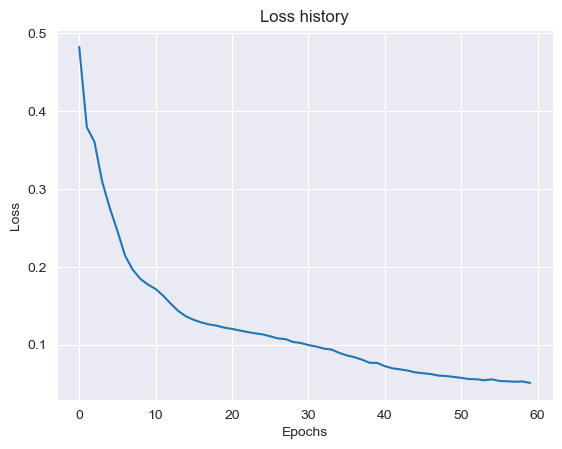

In [17]:
# Plot history loss
plt.plot(history.history['loss'], label='train')
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [18]:
# Evaluate model
score = model.evaluate(x=test_embedding.embedding_arrays,
                       y=test_embedding.embedding_arrays,
                       verbose=1)

94/94 [==============================] - 1s 2ms/step - loss: 0.0298


## Make predictions

In [19]:
def find_closest_embeddings(embedding, emb):
    return sorted(emb.keys(), key=lambda word: spatial.distance.euclidean(emb[word], embedding))[0]

In [20]:
random_index = np.random.randint(0, test_embedding.df.shape[0])

random_embedding = test_embedding.embedding_arrays[random_index:random_index+1]

print("Input - Random passenger data: ")
print(test_embedding.df.iloc[random_index])

prediction = model.predict(x = random_embedding)

#print(prediction)

print("Output - Passenger reconstruction: ")
origin, destination, user_type = [find_closest_embeddings(word_vector, test_embedding.embedding_dict) for word_vector in prediction[0][:3]]
print(f"Origin: {origin}")
print(f"Destination: {destination}")
print(f"User type: {user_type}")

print("Time prediction: ")
month, day, hour, minute = test_embedding.decode_time_embedding(np.array([prediction[0][-1][:6]]))
print(f"Date: 0000-{month}-{day} {hour}:{minute}")

Input - Random passenger data: 
origin                       lleida
destination               tarragona
user_pattern                tourist
date            2023-06-21 04:10:00
Name: 9974, dtype: object
1/1 [==============================] - 0s 371ms/step
Output - Passenger reconstruction: 
Origin: lleida
Destination: tarragona
User type: tourist
Time prediction: 
Date: 0000-6-20 8:44


## Estudio de la correlación entre factores latentes y la entrada del autoencoder

In [21]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [22]:
class ShapModel:
    def __init__(self, model: tf.keras.Model, data: AutoencoderEmbedding, latent_factor: int = 0):
        self.model = model
        self.data = data
        self.df = data.df.copy()
        self.latent_factor = latent_factor
        self.shap_input = self._get_shap_input()
        self.shap_dict = self._get_shap_dict()

    def _get_shap_input(self):
        self.df['total_minutes'] = self.df['date'].apply(lambda dt: dt.dayofyear * 24 * 60 + dt.hour * 60 + dt.minute)
        shap_input = self.df[['origin', 'destination', 'user_pattern', 'total_minutes']].values.tolist()
        shap_input = np.array([np.asarray(row) for row in shap_input])
        return shap_input

    def _get_shap_dict(self):
        embeddings_dict = {}

        for input_array, embedding_array in zip(self.shap_input, self.data.embedding_arrays):
            for input_value, embedding_value in zip(input_array, embedding_array):
                if input_value not in embeddings_dict:
                    embeddings_dict[input_value] = embedding_value

        return embeddings_dict

    def _get_encoded_values(self, row):
        return np.asarray([self.shap_dict.get(value) for value in row])

    def predict(self, X_values):
        X_encoded = np.array([self._get_encoded_values(instance) for instance in X_values])
        predictions = self.model.predict(X_encoded)
        return predictions[:, self.latent_factor]


In [35]:
s_model = ShapModel(encoder_model, test_embedding, latent_factor=1)

In [36]:
s_model.predict(s_model.shap_input)

94/94 [==============================] - 0s 2ms/step


array([ 0.599167  ,  0.6873125 ,  0.25406256, ...,  0.21407475,
       -0.4538895 , -0.43602106], dtype=float32)

In [37]:
explainer = shap.KernelExplainer(s_model.predict, shap.sample(s_model.shap_input, 50), feature_names=['origin', 'destination', 'user_pattern', 'date'])

2/2 [==============================] - 0s 14ms/step


In [38]:
shap_values = explainer(s_model.shap_input[:30])

  0%|          | 0/30 [00:00<?, ?it/s]

22/22 [==============================] - 0s 1ms/step


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


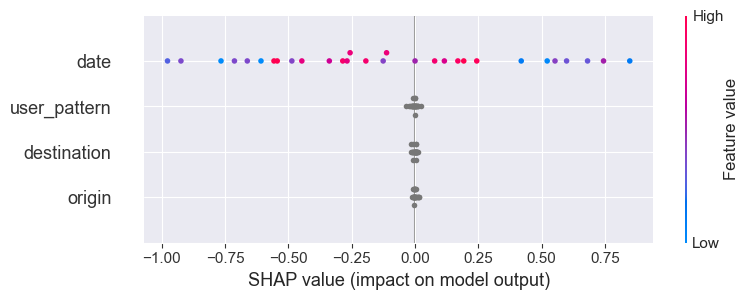

In [39]:
shap.summary_plot(shap_values, s_model.shap_input[:30], show=True)

In [43]:
exp = shap.Explanation(shap_values, explainer.expected_value, data=s_model.shap_input[:10], feature_names=['origin', 'destination', 'user_pattern', 'date'])

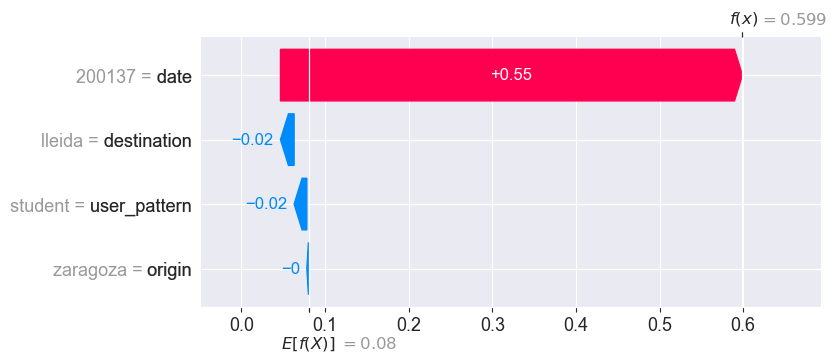

In [44]:
shap.plots.waterfall(exp[0])

# GradCam Interpretability

In [ ]:
ind_img = np.random.randint(0, len(test_embedding.embedding_arrays))
print(ind_img)

img = test_embedding.embedding_arrays[ind_img]
plt.imshow(img, cmap='gray')
plt.grid(False)
plt.show()

In [ ]:
model_feat_layer2 = Model(inputs=encoder_model.inputs, outputs=encoder_model.layers[2].output)
model_feat_layer2.summary()

In [ ]:
feat_test_layer2 = model_feat_layer2.predict(x = test_embedding.embedding_arrays)

print("layer 0 shape {}".format(feat_test_layer2.shape))

In [ ]:
for kfeat in range(0, 32):
    print(feat_test_layer2[ind_img,:,:,0].shape)

In [ ]:
fig = plt.figure(figsize=(18, 18))
for kfeat in range(0, 32):
    ax = fig.add_subplot(12, 4, kfeat+1)
    ax.imshow(feat_test_layer2[ind_img,:,:,kfeat], cmap='gray')
    ax.set_title(f"Feature {kfeat}")
    ax.axis('off')
#encoder_model.layers[2].get_weights()[0][:, kfeat].reshape(12, 8)
plt.show()

In [ ]:
import requests

url = 'https://raw.githubusercontent.com/raulbenitez/ML_DL_INTERPRETABILITY/main/DL/explainabilityModels.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import
with open('explainabilityModels.py', 'w') as f:
    f.write(r.text)

# now we can import
import explainabilityModels

In [ ]:
gradcam = explainabilityModels.make_gradcam_heatmap(img, encoder_model)

In [ ]:
def plot_compareimg(original, filtered, str1):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
    ax1.imshow(original, cmap="gray")
    ax1.set_title('original')
    ax1.axis('off')
    im2 = ax2.imshow(filtered, cmap="jet")
    plt.colorbar(im2,ax=ax2)
    ax2.set_title(str1)
    ax2.axis('off')
    plt.show()

In [ ]:
plot_compareimg(img, gradcam, 'gradCAM')

In [ ]:
occlusion = explainabilityModels.occlusion_map(img, )

In [ ]:
# Latent space for test data
latent_space = encoder_model.predict(x = test_embedding.embedding_arrays)

In [ ]:
def get_pearson_corr(latent_space, col, embedding_data):
    # Get set of values in origin column
    col_values = set(embedding_data.df[col].values)

    # Get dict of origin values and their corresponding GloVe embedding value
    col_embedding_dict = {}
    for value in col_values:
        col_embedding_dict[value] = embedding_data.embedding_dict[value]

    # Get dict with origin values and distance
    total_distance = 0
    prev_embedding = None
    distances_dict = {}
    for i, (value, embedding) in enumerate(col_embedding_dict.items()):
        if i == 0:
            distances_dict[value] = np.float32(0.0)
            prev_embedding = embedding
            continue

        distance = spatial.distance.euclidean(prev_embedding, embedding)
        total_distance += distance
        distances_dict[value] = distance
        prev_embedding = embedding

    col_distances = embedding_data.df[col].apply(lambda x: distances_dict[x]).values

    for j in range(latent_dim):
        lf = latent_space[:, j]
        # Get Pearson correlation between latent factor and distance
        corr, _ = pearsonr(lf, col_distances)
        print(f"Latent factor {j+1} - Pearson correlation: {corr}")

for col in ['origin', 'destination', 'user_pattern']:
    print(f"Column: {col}")
    get_pearson_corr(latent_space, col, test_embedding)

In [ ]:
# Box Plot

def get_boxplot(latent_space: np.array,
                title: str,
                file_name: str
    ) -> None:
    fig, ax = plt.subplots(figsize=(10, 8))
    df_predictions = pd.DataFrame(latent_space, columns = [f"latent_{i}" for i in range(1, latent_space.shape[1]+1)])

    b_plot = df_predictions.boxplot()
    ax.set_ylim(-1, 1)

    ax.set_title(title, weight='bold', fontsize=14)
    ax.xaxis.label.set_size(14)
    fig.savefig(SAVE_PATH + file_name, dpi=300)
    b_plot.plot()

get_boxplot(latent_space, 'Boxplot - Test data latent space', 'boxplot_test_data.png')

In [ ]:
# T-SNE plot

def tsne_plot(latent_space: np.array,
              ae_embedding: AutoencoderEmbedding,
              column: str,
              title: str,
              file_name: str
    ) -> None:
    tsne = TSNE(n_components=2, random_state=SEED)
    tsne_latent_space = tsne.fit_transform(latent_space)

    # Scatter plot tsne_latent_space
    plt.figure(figsize=(10, 10))
    plt.title(title, weight='bold', fontsize=14)

    values_set = set(ae_embedding.df[column].values)
    for i, value in enumerate(values_set):
        plt.scatter(tsne_latent_space[ae_embedding.df[column] == value, 0],
                    tsne_latent_space[ae_embedding.df[column] == value, 1],
                    label=value)
    plt.legend(fontsize=12)
    plt.savefig(SAVE_PATH + file_name, dpi=300, bbox_inches='tight')
    plt.show()

tsne_plot(latent_space=latent_space,
          ae_embedding=test_embedding,
          column='origin',
          title="T-SNE - Test data latent space",
          file_name="tsne_test_data_origin.png")

In [ ]:
tsne_plot(latent_space=latent_space,
          ae_embedding=test_embedding,
          column='user_pattern',
          title="T-SNE - Test data latent space",
          file_name="tsne_test_data_user_pattern.png")

In [ ]:
# PCA on latent space to analyze relationship between latent factors and input variables

def pca_plot(latent_space: np.array,
             ae_embedding: AutoencoderEmbedding,
             column: str,
             title: str,
             file_name: str
    ) -> None:
    pca = PCA(n_components=2, random_state=SEED)
    pca_latent_space = pca.fit_transform(latent_space)

    # Scatter plot pca_latent_space with legend of origin
    plt.figure(figsize=(10, 10))
    plt.title(title, weight='bold', fontsize=14)

    values_set = set(ae_embedding.df[column].values)
    for i, value in enumerate(values_set):
        plt.scatter(pca_latent_space[ae_embedding.df[column] == value, 0],
                    pca_latent_space[ae_embedding.df[column] == value, 1],
                    label=value)

    plt.legend(fontsize=12)
    plt.savefig(SAVE_PATH + file_name, dpi=300, bbox_inches='tight')
    plt.show()

pca_plot(latent_space=latent_space,
         ae_embedding=test_embedding,
         column='origin',
         title="PCA - Test data latent space",
         file_name="pca_test_data_origin.png")

In [ ]:
pca_plot(latent_space=latent_space,
         ae_embedding=test_embedding,
         column='user_pattern',
         title="PCA - Test data latent space",
         file_name="pca_test_data_user_pattern.png")

## Test data analysis with locked columns

In [ ]:
def get_locked_dataframe(df: pd.DataFrame,
                         locked_columns: list,
                         seed: int = SEED
    ) -> pd.DataFrame:
    """
    Get a dataframe with locked columns (all rows with the same value)

    Args:
        df (pd.DataFrame): Dataframe to lock
        locked_columns (list): List of columns to lock
        seed (int): Random seed

    Returns:
        pd.DataFrame: Locked dataframe
    """
    random.seed(seed)
    df_locked = df.copy()

    for column in locked_columns:
        values = tuple(set(df_locked[column].values))
        locked_value = random.sample(values, 1)[0]
        df_locked[column] = locked_value

    return df_locked

locked_dataframe = get_locked_dataframe(df=test_embedding.df,
                                        locked_columns=['destination', 'user_pattern', 'date'])

locked_embedding = AutoencoderEmbedding(df=locked_dataframe, embedding_dim=EMBEDDING_DIM, noise=False)
display(locked_embedding.df.head())

# Get latent space of the locked_embedding
latent_space = encoder_model.predict(x = locked_embedding.embedding_arrays)

# Get range of values for each latent factor
latent_space_range = pd.DataFrame(latent_space).describe().loc[['min', 'max']]

print("Latent space range: ")
print(latent_space_range)

In [ ]:
get_boxplot(latent_space, 'Boxplot - Changes only in origin', 'boxplot_unlock_origin.png')

In [ ]:
# T-SNE

tsne_plot(latent_space=latent_space,
          ae_embedding=locked_embedding,
          column='origin',
          title="T-SNE - Changes in origin column",
          file_name="tsne_origin_unlock")

In [ ]:
latent_factors_range = []
num_iters = 30

df_latent = pd.DataFrame()
for i in range(1, num_iters+1):
    print(f"Iter {i}...")
    locked_dataframe = get_locked_dataframe(test_embedding.df, locked_columns=['destination', 'user_pattern', 'date'], seed=i)
    locked_embedding = AutoencoderEmbedding(df=locked_dataframe, embedding_dim=EMBEDDING_DIM, noise=False)
    locked_latent_space = encoder_model.predict(x = locked_embedding.embedding_arrays, verbose=0)
    latent_space_range = pd.DataFrame(locked_latent_space).describe().loc[['min', 'max']]
    if i == 1:
        df_latent = pd.DataFrame(locked_latent_space, columns = [f"latent_{i}" for i in range(1, locked_latent_space.shape[1]+1)])
    else:
        df_latent = pd.concat([df_latent, pd.DataFrame(locked_latent_space, columns = [f"latent_{i}" for i in range(1, locked_latent_space.shape[1]+1)])], axis=0)
    print(latent_space_range)
    latent_factors_range.append(latent_space_range)

In [ ]:
latent_factors = [list(zip(*lfr.values)) for lfr in latent_factors_range]

df = pd.DataFrame(latent_factors, columns = [f'latent_{i}' for i in range(len(latent_factors[0]))])
display(df)

In [ ]:
def float_range_intersection(first_pair, second_pair):
    x0, y0 = first_pair
    x1, y1 = second_pair

    if y0 < x1 or y1 < x0:
      return None

    return max(x0, x1), min(y0, y1)

for col in df.columns:
    column_values = df[col].values
    for i in range(len(column_values)-1):
        if i == 0:
            first_pair = column_values[i]
        second_pair = column_values[i+1]
        intersection = float_range_intersection(first_pair, second_pair)
        if not intersection:
            print(f"Zero intersection for colum  {col}")
            break
        first_pair = intersection
    else:
        print(f"Final intersection for column {col}: {intersection}")

In [ ]:
# Plot density of each column in df_latent dataframe
import seaborn as sns

plt.figure(figsize=(9, 7))

for col in df_latent.columns:
    sns.kdeplot(df_latent[col], label=col)

plt.title(f"Density plot - Changes only in origin column", weight='bold', fontsize=14)
plt.xlabel("Range of latent space values", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=12)
plt.savefig(SAVE_PATH + f"density_origin_unlock.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
granularity = 0.05
bins = np.arange(-1, 1+granularity, granularity)
print(bins)

df_bins = pd.DataFrame()
for col in df_latent.columns:
    df_bins[f'bucket_{col}'] = pd.cut(df_latent[col], bins=bins)

print(df_bins.head())

In [ ]:
df_intervalos = pd.DataFrame()

for col in df_bins.columns:
    df_intervalos[f"count_{col}"] = df_bins.groupby(col).size().sort_index()

df_intervalos.index.name = 'bins'
print(df_intervalos)

In [ ]:
xdat = []
ydat = []
for i, col in enumerate(df_latent.columns):
    xdat.extend([i for _ in range(df_latent.shape[0])])
    ydat.extend(df_latent[col].values)

x_dat = np.array(xdat)
y_dat = np.array(ydat)

In [ ]:
#histogram definition

xyrange = [[0,5],[-1,1]] # data range
bins = [5,50] # number of bins
thresh = 3  #density threshold
xtick_positions = np.arange(0.5, len(df_latent.columns) + 0.5)

#data definition
N = 10000
#xdat, ydat = np.random.normal(3, 0.8, size=N), np.random.normal(0, 0.3, size=N)

# histogram the data
hh, locx, locy = np.histogram2d(xdat, ydat, range=xyrange, bins=bins)
posx = np.digitize(xdat, locx)
posy = np.digitize(ydat, locy)

#select points within the histogram
ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

plt.figure(figsize=(10,9))
plt.title("Heatmap - Changes only in origin column", weight='bold', fontsize=14)
plt.tick_params(axis='x',          # changes apply to the x-axis
                which='major',     # major are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
plt.xticks(np.arange(0.5, len(df_latent.columns)+0.5), df_latent.columns, minor=True)
plt.yticks(np.arange(-1, 1.1, 0.25))
plt.xlabel("Latent factor", fontsize=12, labelpad=10)
plt.ylabel("Range of latent space values", fontsize=12)
plt.grid(alpha=0.4)

img = plt.imshow(np.flipud(hh.T), cmap='turbo', extent=np.array(xyrange).flatten(), interpolation='none', origin='upper')

# Add a colorbar, which uses the Image as a mappable (a scalar data to RGBA mapping).
cbar = plt.colorbar(img, orientation='horizontal')
cbar.set_label('Color bar', labelpad=15, fontsize=12)

plt.savefig(SAVE_PATH + f"histogram_origin_unlock.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Calculate Pearson correlation
pearson_corr = []
p_values_pearson = []
for i in range(latent_dim):
    correlation, p_value = pearsonr(latent_space[:, i], test_embedding.df_embedding['origin'])
    pearson_corr.append(correlation)
    p_values_pearson.append(p_value)

# Calculate Spearman correlation
spearman_corr = []
p_values_spearman = []
for i in range(latent_dim):
    correlation, p_value = spearmanr(latent_space[:, i], test_embedding.df_embedding['origin'])
    spearman_corr.append(correlation)
    p_values_spearman.append(p_value)

# Create dataframe with results
resultados_correlacion = pd.DataFrame({'Latent factor': range(1, 6),
                                      'Pearson correlation': pearson_corr,
                                      'Pearson p-value': p_values_pearson,
                                      'Spearman correlation': spearman_corr,
                                      'Spearman p-valus': p_values_spearman})

# Print results
display(resultados_correlacion)
print()

In [ ]:
df_test = test_embedding.df.copy()
df_test['date'] = df_test['date'].apply(lambda x: np.float32(int(datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds())
))
df_test = pd.get_dummies(df_test, columns=['origin', 'destination', 'user_pattern', 'date'])

# df_test to numpy array
df_test = df_test.to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_test,
                                                    latent_space,
                                                    test_size=0.2,
                                                    random_state=0)

# Train MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes=(100, 100, 100),
                         activation='relu',
                         solver='adam',
                         max_iter=1000,
                         random_state=0).fit(X_train, y_train)

# Evaluate MLPRegressor
print(f"Train score: {regressor.score(X_train, y_train)}")
print(f"Test score: {regressor.score(X_test, y_test)}")